In [32]:
import kinodata
from kinodata.data import KinodataDocked
from kinodata.transform import TransformToComplexGraph
from kinodata.types import *


import json
from pathlib import Path
from typing import Any

import torch

import kinodata.configuration as cfg
from kinodata.model import ComplexTransformer, DTIModel, RegressionModel
from kinodata.model.complex_transformer import make_model as make_complex_transformer
from kinodata.model.dti import make_model as make_dti_baseline
from kinodata.data.data_module import make_kinodata_module
from kinodata.transform import TransformToComplexGraph

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import tqdm

!wandb disabled

W&B disabled.


In [2]:
data = KinodataDocked()

In [34]:
# transform concatenates pocket and ligand nodes (in that order)
transform = TransformToComplexGraph() # pocket - ligand
graf = transform(data[0])

In [35]:
model_dir = Path("..") / "models"
assert model_dir.exists()

def path_to_model(rmsd_threshold: int, split_type: str, split_fold: int, model_type: str) -> Path:
    p = model_dir / f"rmsd_cutoff_{rmsd_threshold}" / split_type / str(split_fold) / model_type
    if not p.exists():
        p.mkdir(parents=True)
    return p
model_cls = {
    "DTI": make_dti_baseline,
    "CGNN": make_complex_transformer,
    "CGNN-3D": make_complex_transformer
}

def load_wandb_config(
    config_file: Path
) -> dict[str, Any]:
    with open(config_file, "r") as f_config:
        config = json.load(f_config)
    config = {str(key): value["value"] for key, value in config.items()}
    return config

def load_from_checkpoint(
    rmsd_threshold: int,
    split_type: str,
    fold: int,
    model_type: str
) -> RegressionModel:
    cls = model_cls[model_type]
    p = path_to_model(rmsd_threshold, split_type, fold, model_type)
    model_ckpt = list(p.glob("**/*.ckpt"))[0]
    model_config = p / "config.json"
    ckp = torch.load(model_ckpt, map_location="cpu")
    config = cfg.Config(load_wandb_config(model_config))
    model = cls(config)
    assert isinstance(model, RegressionModel)
    model.load_state_dict(ckp["state_dict"])
    return model

In [36]:
cgnn_3d = load_from_checkpoint(2, "scaffold-k-fold", 0, "CGNN-3D")
cgnn_3d.train(False)

ComplexTransformer(
  (criterion): MSELoss()
  (act): SiLU()
  (interaction_module): CombinedInteractions(
    (interactions): ModuleList(
      (0): CovalentInteractions(
        (act): SiLU()
        (lin): Linear(in_features=4, out_features=256, bias=True)
      )
      (1): StructuralInteractions(
        (act): SiLU()
        (distance_embedding): GaussianDistEmbedding()
        (lin): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    (act): SiLU()
  )
  (atomic_num_embedding): Embedding(100, 256)
  (lin_atom_features): Linear(in_features=12, out_features=256, bias=True)
  (attention_blocks): ModuleList(
    (0-2): 3 x SPAB(
      (attention): SparseAttention(
        (lin_query): Linear(in_features=256, out_features=256, bias=False)
        (lin_key_value): Linear(in_features=256, out_features=512, bias=False)
        (lin_bias): Linear(in_features=256, out_features=512, bias=False)
        (lin_out): Linear(in_features=256, out_features=256, bias=False)
   

In [37]:
n_complex = graf[NodeType.Complex].x.shape[0]
n_ligand = graf[NodeType.Ligand].z.shape[0]
n_pocket = graf[NodeType.Pocket].z.shape[0]

In [52]:
graf[NodeType.Complex].batch = torch.zeros(graf[NodeType.Complex].x.shape[0]).type(torch.int64)
graf

HeteroData(
  y=[1],
  docking_score=[1],
  posit_prob=[1],
  predicted_rmsd=[1],
  pocket_sequence='KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVEFCKFGNLSTYLRSFLASRKCIHRDLAARNILLICDFGLA',
  scaffold='C1CCC(CC2CCCC(C3CC(C4CCCC4)C4CCCCC34)C2)CC1',
  activity_type='pIC50',
  ident=[1],
  smiles='Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1',
  ligand={
    z=[28],
    x=[28, 12],
    pos=[28, 3],
  },
  pocket={
    z=[652],
    x=[652, 12],
    pos=[652, 3],
  },
  pocket_residue={ x=[85, 23] },
  complex={
    x=[680, 12],
    z=[680],
    pos=[680, 3],
    batch=[680],
  },
  (ligand, bond, ligand)={
    edge_index=[2, 64],
    edge_attr=[64, 4],
  },
  (pocket, bond, pocket)={
    edge_index=[2, 1308],
    edge_attr=[1308, 4],
  },
  (complex, bond, complex)={
    edge_index=[2, 1372],
    edge_attr=[1372, 4],
  }
)

In [53]:
cgnn_3d(graf)

tensor([[6.1949]], grad_fn=<AddmmBackward0>)

In [54]:
structural_interactions = cgnn_3d.interaction_module.interactions[1]
edges, _ = structural_interactions(graf)

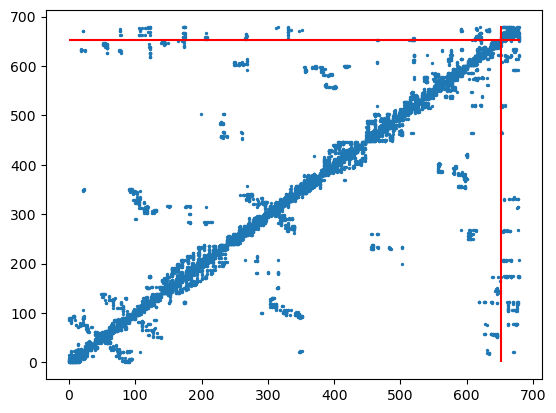

In [55]:
plt.scatter(*edges, s=2)
plt.vlines(n_pocket, 0, n_complex, 'r')
plt.hlines(n_pocket, 0, n_complex, 'r')

Compute pocket-ligand edge subset.

In [58]:
edge_in_pocket = edges < n_pocket
pl_edges = edge_in_pocket[0] ^ edge_in_pocket[1]

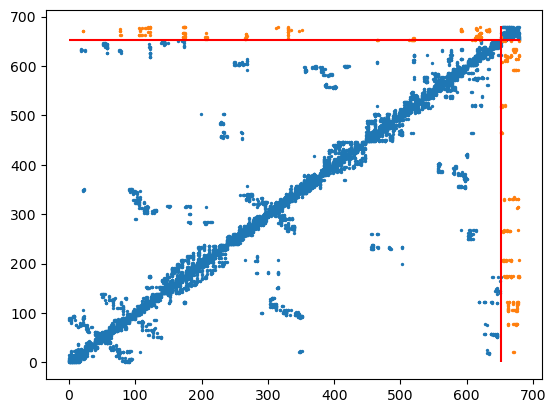

In [59]:
plt.scatter(*(edges.T[~pl_edges].T), s=2)
plt.scatter(*(edges.T[pl_edges].T), s=2)
plt.vlines(n_pocket, 0, n_complex, 'r')
plt.hlines(n_pocket, 0, n_complex, 'r')

In [60]:
def get_pl_edges(cgnn_3d, data):
    structural_interactions = cgnn_3d.interaction_module.interactions[1]
    edges, _ = structural_interactions(data)
    edge_in_pocket = edges < n_pocket
    pl_edges = edge_in_pocket[0] ^ edge_in_pocket[1]
    pl_edge_idcs = torch.where(pl_edges)[0]
    return pl_edges, pl_edge_idcs

In [61]:
pl_edges, pl_edge_idcs = get_pl_edges(cgnn_3d, graf)

# General importance of PL interactions

In [76]:
cgnn_3d.train(False)
deltas = []
pl_complex = []
references = []

with torch.no_grad():
    for i in range(5):
        print('complex', i)
        graf = transform(data[i])
        graf[NodeType.Complex].batch = torch.zeros(graf[NodeType.Complex].x.shape[0]).type(torch.int64)
        structural_interactions.hacky_mask = None
        edges, _ = structural_interactions(graf)
        structural_interactions.hacky_mask = torch.ones(len(edges.T)).type(torch.bool)
        pl_edges, pl_edge_idcs = get_pl_edges(cgnn_3d, graf)
        with torch.no_grad():
            reference_prediction = cgnn_3d(graf)
            references.append(reference_prediction[0][0].item())
            for candidate_edge in tqdm.tqdm(pl_edge_idcs):
        
                # Compute change against reference prediction
                structural_interactions.hacky_mask[candidate_edge] = False
                deltas.append((reference_prediction - cgnn_3d(graf)[0]).item())
                pl_complex.append(i)
                structural_interactions.hacky_mask[candidate_edge] = True
deltas = pd.DataFrame({'delta': deltas, 'complex': pl_complex})

complex 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [01:09<00:00,  4.58it/s]


complex 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [01:17<00:00,  4.21it/s]


complex 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [01:07<00:00,  4.38it/s]


complex 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [01:28<00:00,  3.96it/s]


complex 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [01:12<00:00,  4.08it/s]


<Axes: xlabel='complex', ylabel='delta'>

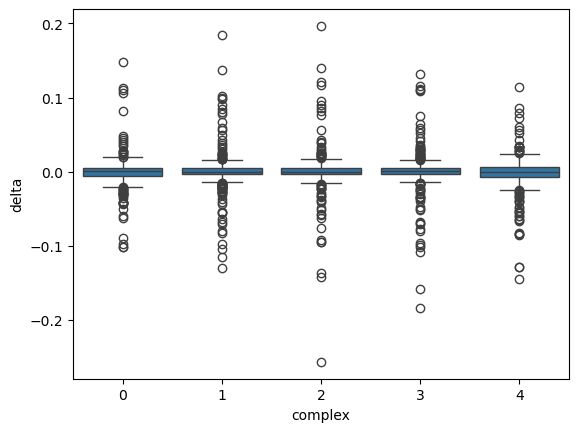

In [79]:
sns.boxplot(deltas, x='complex', y='delta')

# 'Minimal' binding explanation

In [80]:
with torch.no_grad():
    cut_edges = []
    structural_interactions.hacky_mask = torch.ones(len(edges.T)).type(torch.bool)
    reference_prediction = cgnn_3d(graf)
    snap = False
    print('reference prediction:', reference_prediction[0][0].item())
    cur_prediction = reference_prediction[0]
    while (reference_prediction - cur_prediction).abs().item() < 0.1:
        cut_candidates = []
        for candidate_edge in tqdm.tqdm(pl_edge_idcs):
            if candidate_edge in cut_edges:
                continue

            # Compute change against reference prediction
            structural_interactions.hacky_mask[candidate_edge] = False
            delta = (reference_prediction - cgnn_3d(graf)[0]).abs().item()
            structural_interactions.hacky_mask[candidate_edge] = True

            if delta < 0.01:
                cut_candidates.append(candidate_edge.item())

        if len(cut_candidates) == 0:
            break
        cut_edges.extend(cut_candidates)
        for edge in cut_edges:
            structural_interactions.hacky_mask[edge] = False
        cur_prediction = cgnn_3d(graf)[0][0]
        print('cut edges:', cut_edges, 'current pred:', cur_prediction)
print(f'Removed {len(cut_edges)} out of {len(pl_edge_idcs)} PL interactions.')

reference prediction: 5.692282199859619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [01:11<00:00,  4.18it/s]


cut edges: [1203, 1206, 1215, 1226, 1227, 1239, 1240, 1659, 1660, 1676, 1677, 1701, 1713, 1730, 1932, 1949, 1963, 1965, 1982, 2744, 2745, 2762, 2766, 2767, 2796, 2799, 3284, 3287, 3290, 3292, 3298, 3308, 3315, 3317, 3319, 3320, 3322, 4116, 4167, 4198, 4212, 4217, 4218, 4233, 4234, 4248, 4949, 4985, 5224, 5234, 5256, 5258, 5259, 7374, 7377, 8229, 9382, 9384, 9667, 9678, 9683, 9694, 9695, 9717, 9730, 9733, 9781, 9783, 9799, 9813, 9831, 9832, 9868, 9972, 9999, 10014, 10030, 10038, 10047, 10053, 10064, 10067, 10071, 10328, 10330, 10336, 10343, 10346, 10356, 10357, 10361, 10362, 10363, 10371, 10372, 10373, 10374, 10376, 10378, 10388, 10389, 10390, 10391, 10392, 10395, 10405, 10406, 10410, 10411, 10412, 10423, 10424, 10426, 10427, 10428, 10439, 10440, 10441, 10442, 10444, 10445, 10456, 10457, 10458, 10459, 10462, 10470, 10473, 10474, 10476, 10477, 10479, 10492, 10495, 10508, 10509, 10510, 10511, 10512, 10528, 10544, 10545, 10547, 10563, 10575, 10578, 10579, 10591, 10592, 10595, 10596, 10597,